<div style='background-color: rgb(245, 238, 233); padding: 10px;'>
    
---
    
# Stock direction prediction tool

My main purpose of this project is to create the most accurate classificator, that **will tell whether the price of some stock/cryptocurrency will go up next day or not.** <br><br>
I will evaluate the models on **Bitcoin** data first, create some usefull functions and tools in order to reuse them later on other stocks.<br><br>
After the models will be created, I want to implement them into some sort of application, allowing to get the information about the potential increase.

**I want to include these cryptos inside my app:**

> **Bitcoin** - BTC-USD<br>
> **Ethereum** - ETH-USD<br>
> **BNB** - BNB-USD<br>
> **Dogecoin** - DOGE-USD<br>
---
</div>

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>
    
---
    
# Why not predict stock price?

It's way better to predict the **return/direction** of the stock, rather than the actuall future price. The stock market is **unstationary**,
so **no statistical model will be good here**, in terms of **machine learning algorythms**, like **LSTM**, **Decision Trees**, and its **Ensembles**, the problem is with **Extrapolation** of the stock price.<br>
<br>
So that's the reason.<br><br>

Another thing I want to mention is that, I am going to first evaluate models using different indicators with mostly **fixed edge values**.<br><br>

---
</div>

In [312]:
import yfinance
import matplotlib.pyplot as plt
import matplotlib.collections as mcollections
import matplotlib.colors as mcolors
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, r2_score, roc_auc_score, RocCurveDisplay, classification_report,\
                                confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

from functools import partial

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
# Getting the data

I am going to work on Yahoo Stock data, which shows different daily stock prices.

---

</div>

In [313]:
bitcoin = yfinance.Ticker("BTC-USD")
ethereum = yfinance.Ticker("ETH-USD")
bincoin = yfinance.Ticker("BNB-USD")
dogecoin = yfinance.Ticker("DOGE-USD")

currency_names = ["Bitcoin", "Ethereum",
                  "Binance Coin", "Dogecoin"]

currencies_data = [bitcoin.history(period="max"), ethereum.history(period="max"),
                   bincoin.history(period="max"), dogecoin.history(period="max")]

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
# Quick look at some cryptocurrencies

As the data is already clean, I will perform **Feature engineering** and **Feature selection**, supported by some analysis.

---
</div>

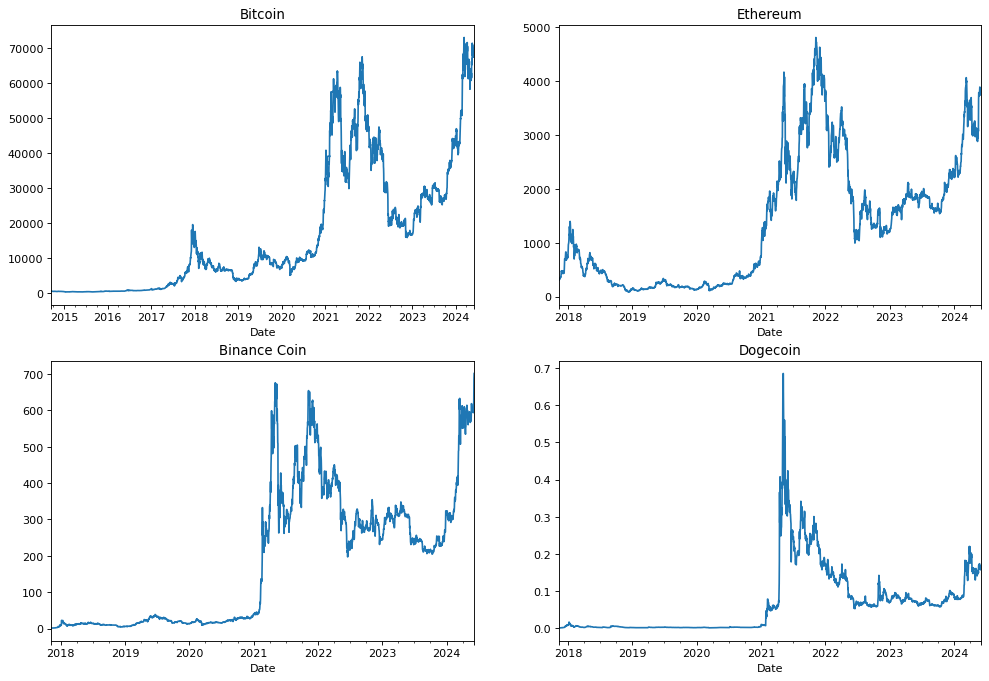

In [314]:
fig, axes = plt.subplots(figsize=(15,10), dpi=80, nrows=2, ncols=2)

for ax, name, data in zip(axes.flatten(), currency_names, currencies_data):
    data["Close"].plot(ax=ax)
    ax.set_title(name)

In [315]:
bitcoin_data = currencies_data[0]
bitcoin_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0


<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Relative Strength Index

---
</div>

In [316]:
def RSI(data: pd.Series, window: int = 14) -> pd.Series:
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

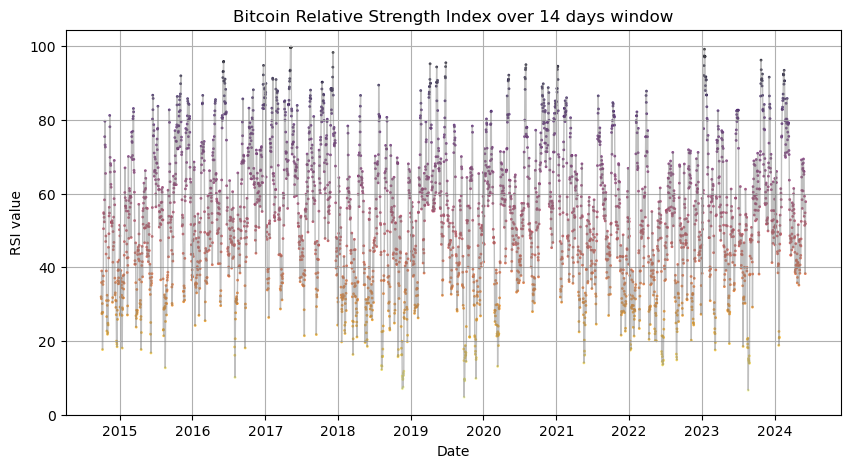

In [317]:
BTC_RSI = RSI(bitcoin_data["Close"])

plt.figure(figsize=(10,5), dpi=100)
plt.grid()
plt.plot(BTC_RSI.index, BTC_RSI.values, alpha=0.5, linewidth=1, color="gray")
plt.scatter(BTC_RSI.index, BTC_RSI.values, alpha=0.8, c=BTC_RSI, edgecolor="None", s=4, marker="o", cmap="inferno_r")
plt.title("Bitcoin Relative Strength Index over 14 days window")
plt.xlabel("Date")
plt.ylabel("RSI value")


plt.show()

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---

### Moving Average Convergence Divergence

This is the only indicator, that does not have fixed, stable values. However I can make a **threshold**.<br><br>

If the histogram's value exceedes the current maximum -> It is going to be cut to the max value.

---
</div>

In [318]:
def MACD_hist(data: pd.Series) -> pd.Series:
    EMA12 = data.ewm(span=12, adjust=False).mean()
    EMA26 = data.ewm(span=26, adjust=False).mean()
    
    MACD = EMA12 - EMA26
    signal_line = MACD.ewm(span=9, adjust=False).mean()

    MACD_HIST = MACD - signal_line
    MAX_MACD = MACD_HIST.max()
    MIN_MACD = MACD_HIST.min()

    # I also return the MAX_MACD and MIN_MACD for the training data in order to deal with extrapolation on test data
    return MACD_HIST, MAX_MACD, MIN_MACD

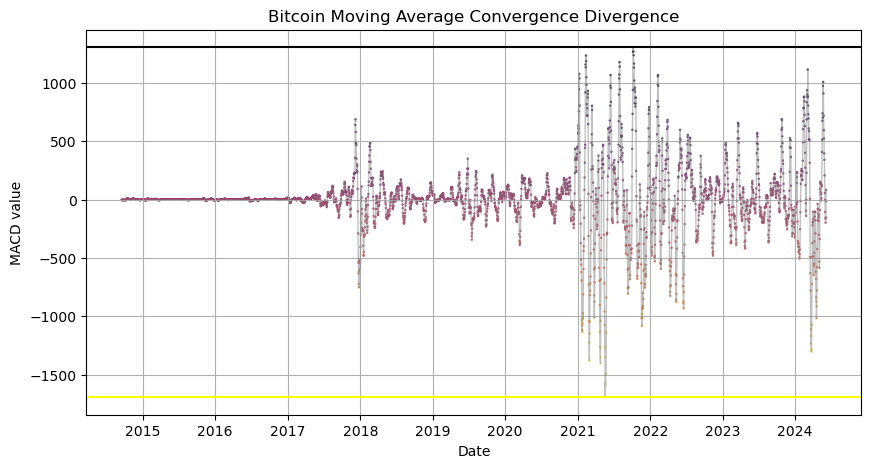

In [319]:
BTC_MACD, mmin, mmax = MACD_hist(bitcoin_data["Close"])

plt.figure(figsize=(10,5), dpi=100)
plt.grid()
plt.plot(BTC_MACD.index, BTC_MACD.values, alpha=0.5, linewidth=1, color="gray")
plt.axhline(mmin, c="black")
plt.axhline(mmax, c="yellow")
plt.scatter(BTC_MACD.index, BTC_MACD.values, alpha=0.8, c=BTC_MACD, edgecolor="None", s=3, marker="o", cmap="inferno_r")
plt.title("Bitcoin Moving Average Convergence Divergence")
plt.xlabel("Date")
plt.ylabel("MACD value")

plt.show()

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---

### Commodity Channel Index

It is highly similiar to MACD indicator, however it keeps its values in bounds **(-100)   -   (100)**.
<br>I will check the correlation, and if it will be really high, I will choose this indicator above MACD.

---
</div>

In [320]:
def CCI(high: pd.Series, low: pd.Series, close: pd.Series, window: int = 20) -> pd.Series:
    TP = (high + low + close) / 3
    MA = TP.rolling(window=window).mean()
    
    CCI = ((TP - MA) / (0.015 * np.mean(np.absolute(TP - np.mean(TP)))))
    return CCI

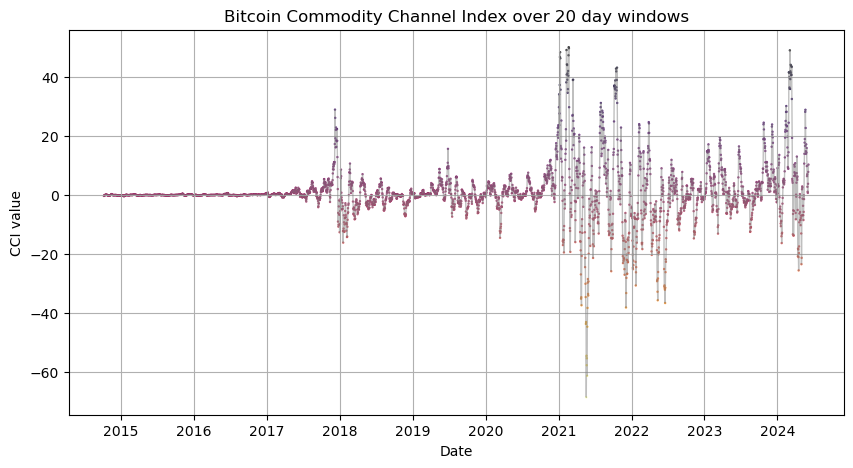

In [321]:
BTC_CCI = CCI(bitcoin_data["High"], bitcoin_data["Low"], bitcoin_data["Close"], window=20)

plt.figure(figsize=(10,5), dpi=100)
plt.grid()
plt.plot(BTC_CCI.index, BTC_CCI.values, alpha=0.5, linewidth=1, color="gray")
plt.scatter(BTC_CCI.index, BTC_CCI.values, alpha=0.8, c=BTC_CCI, edgecolor="None", s=3, marker="o", cmap="inferno_r")
plt.title("Bitcoin Commodity Channel Index over 20 day windows")
plt.xlabel("Date")
plt.ylabel("CCI value")

plt.show()

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---

### Stochastic Oscilator

---
</div>

In [322]:
def stochastic_oscilator(data: pd.Series, window: int = 14) -> pd.Series:
    last_x_max = data.rolling(window).max()
    last_x_min = data.rolling(window).min()

    return 100 * (data - last_x_min) / (last_x_max - last_x_min)

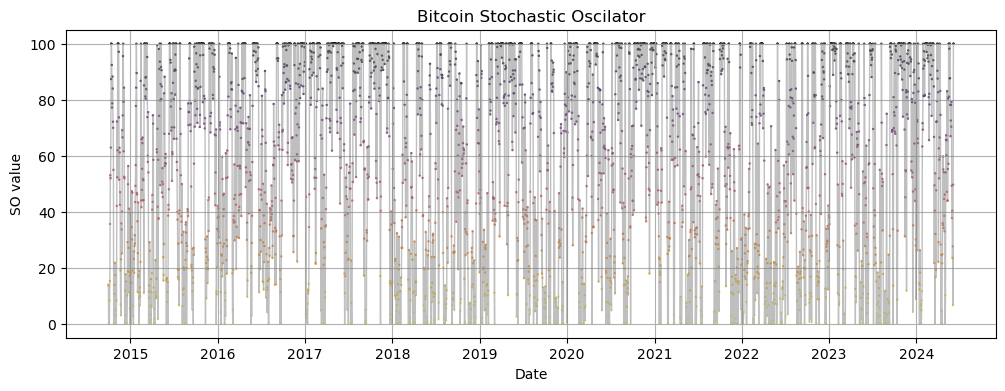

In [323]:
BTC_SO = stochastic_oscilator(bitcoin_data["Close"], window=14)

plt.figure(figsize=(12,4), dpi=100)
plt.grid()
plt.plot(BTC_SO.index, BTC_SO.values, alpha=0.5, linewidth=1, color="gray")
plt.scatter(BTC_SO.index, BTC_SO.values, alpha=0.8, c=BTC_SO, edgecolor="None", s=3, marker="o", cmap="inferno_r")
plt.title("Bitcoin Stochastic Oscilator")
plt.xlabel("Date")
plt.ylabel("SO value")

plt.show()

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Feature creation

Now I will create features based on the previously implemented indicators.<br><br>

I am not going to use **Moving Average** or **Exponential Moving Average**, their scent is included in above functions, they are not stationary, and they extrapolate.

---
</div>

In [324]:
RSI_windows = [3, 5, 7, 14, 20]
CCI_windows = [3, 5, 7, 14, 20]
SO_windows = [3, 5, 7, 14]

raw_features = ["Growth"]

for window in RSI_windows:
    bitcoin_data[f"RSI{window}"] = RSI(bitcoin_data["Close"], window=window)
    raw_features.append(f"RSI{window}")

for window in CCI_windows:
    bitcoin_data[f"CCI{window}"] = CCI(bitcoin_data["High"], bitcoin_data["Low"], bitcoin_data["Close"], window=window)
    raw_features.append(f"CCI{window}")

for window in SO_windows:
    bitcoin_data[f"SO{window}"] = stochastic_oscilator(bitcoin_data["Close"], window=window)
    bitcoin_data[f"SOMA3{window}"] = bitcoin_data[f"SO{window}"].rolling(3).mean()
    raw_features.append(f"SO{window}")
    raw_features.append(f"SOMA3{window}")

bitcoin_data["MACD"] = MACD_hist(bitcoin_data["Close"])[0]
raw_features.append("MACD")


# TARGET VARIABLE
bitcoin_data["Growth"] = (bitcoin_data["Close"] < bitcoin_data["Close"].shift(-1)).astype(int)

In [325]:
bitcoin_data = bitcoin_data.dropna()[:-1]
bitcoin_data = bitcoin_data[raw_features]
bitcoin_data.tail()

,Growth,RSI3,RSI5,RSI7,RSI14,RSI20,CCI3,CCI5,CCI7,CCI14,CCI20,SO3,SOMA33,SO5,SOMA35,SO7,SOMA37,SO14,SOMA314,MACD
Date,,,,,,,,,,,,,,,,,,,,
2024-05-31 00:00:00+00:00,1,33.082398,38.208296,41.143033,51.382233,62.436823,-1.110680,-2.728420,-3.486064,-3.500953,2.822172,0.000000,33.333333,0.000000,14.440139,0.000000,14.440139,23.463969,33.857128,-107.032625
2024-06-01 00:00:00+00:00,1,53.434002,27.147799,35.338779,52.393558,61.814035,-1.098603,-1.454158,-2.837697,-3.986255,1.141809,24.671341,41.557114,24.671341,22.663919,11.324620,18.215012,27.632840,30.486134,-163.736381
2024-06-02 00:00:00+00:00,1,22.948967,39.680547,41.693097,54.787493,59.669611,0.438656,-0.196318,-1.465309,-3.561979,0.736521,100.000000,41.557114,29.784113,18.151818,13.671481,8.332033,6.575736,19.224182,-198.517716
2024-06-03 00:00:00+00:00,1,100.000000,70.624613,43.844093,38.271960,64.630465,3.352183,3.523202,3.499472,1.318126,3.832572,100.000000,74.890447,100.000000,51.485151,100.000000,41.665367,49.652514,27.953697,-152.921634
2024-06-04 00:00:00+00:00,1,100.000000,77.883704,70.820957,51.839587,59.848485,5.026004,7.220180,7.644324,6.657570,7.871841,100.000000,100.000000,100.000000,76.594704,100.000000,71.223827,100.000000,52.076083,-13.690150


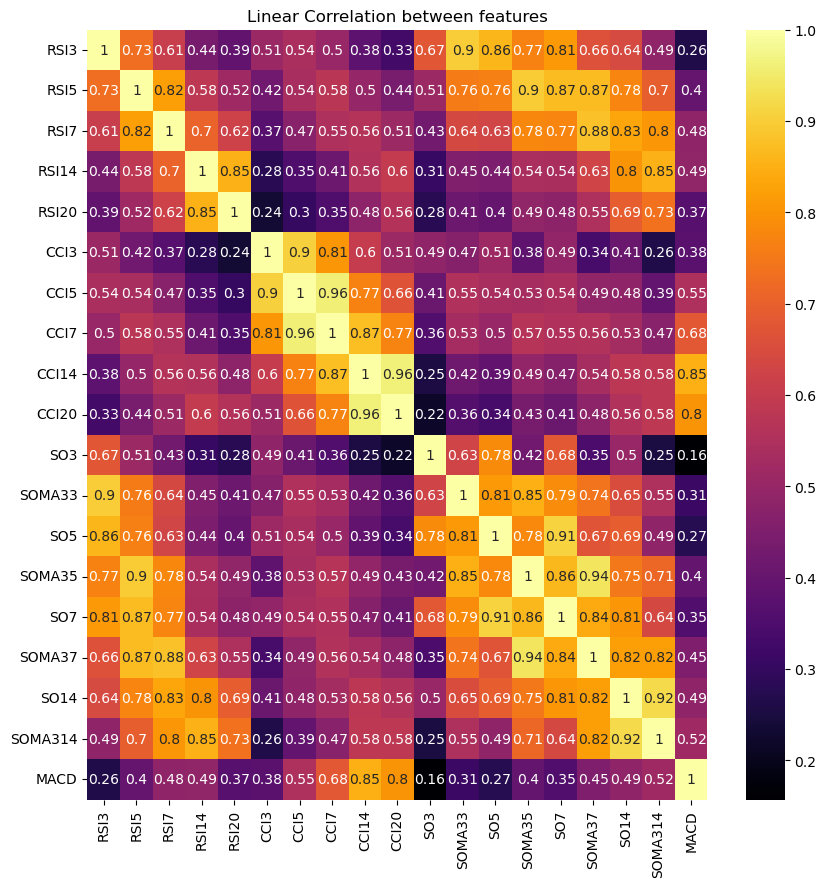

In [326]:
plt.figure(figsize=(10,10), dpi=100)
sns.heatmap(bitcoin_data.drop("Growth", axis=1).corr(), annot=True, cmap="inferno")
plt.title("Linear Correlation between features")
plt.show()

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Quick validation function

This function will help evaluate the estimators, where the predictions are made for next 300 days (on default).<br>
It doesn't include the cross-validation, it is just a pure quick test.

---
</div>

In [327]:
features = raw_features[1:]

def check_model(model, data: pd.DataFrame, features: list, target: str, test_size: int = 300, threshold: float = 0.6):
    X = bitcoin_data[features].values
    y = bitcoin_data[target].values

    n_size = len(X)

    # Train Test Split
    X_train = X[:n_size-test_size, :]
    X_test = X[n_size-test_size:, :]
    
    y_train = y[:n_size-test_size]
    y_test = y[n_size-test_size:]

    # Fitting the model
    model.fit(X_train, y_train)

    # Predicting with a threshold
    y_pred = model.predict_proba(X_test)[:,1]
    y_pred[y_pred > threshold] = 1
    y_pred[y_pred <= threshold] = 0

    # Displaying the results
    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.show()


<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### I will start with Random Forest and check it's performance

---
</div>

              precision    recall  f1-score   support

           0       0.49      0.75      0.60       141
           1       0.59      0.31      0.41       159

    accuracy                           0.52       300
   macro avg       0.54      0.53      0.50       300
weighted avg       0.54      0.52      0.50       300



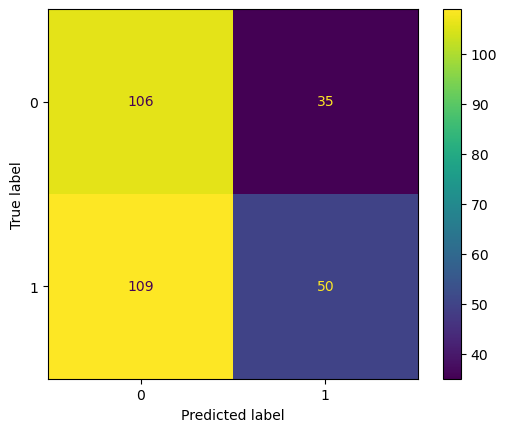

In [328]:
rf = RandomForestClassifier(bootstrap=False)

check_model(rf, bitcoin_data, features, "Growth")

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Feature selection

I will perform feature selection based on different methods:

- **Random Forest feature importances**
- **Recursive Feature Elimination**

---
</div>

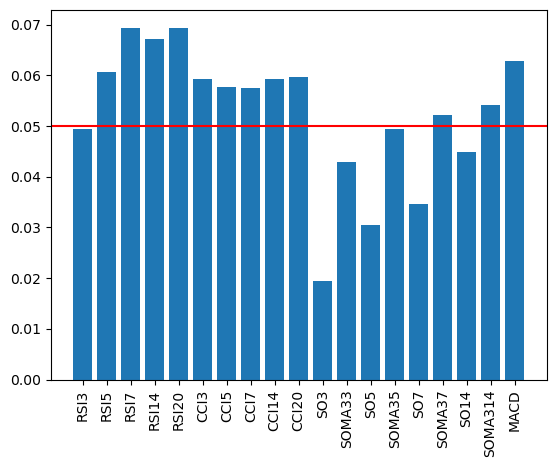

In [334]:
plt.bar(range(1, len(features)+1), rf.feature_importances_)
plt.axhline(0.05, c='r')
plt.xticks(range(1, len(features)+1), features)
plt.xticks(rotation=90)
plt.show()

In [331]:
rfe = RFE(RandomForestClassifier())
rfe.fit(bitcoin_data[features], bitcoin_data["Growth"])

RFE(estimator=RandomForestClassifier())

In [333]:
features_rfe = list(np.array(features)[rfe.ranking_ == 1])
features_rfe

['RSI5', 'RSI7', 'RSI14', 'RSI20', 'CCI3', 'CCI5', 'CCI20', 'SOMA314', 'MACD']

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Entry evaluation on different features

---
</div>

In [335]:
features_rfe = ["RSI5", "RSI7", "RSI14", "RSI20", "CCI3", "CCI5", "CCI20", "SOMA314", "MACD"]# results

              precision    recall  f1-score   support

           0       0.49      0.82      0.61       141
           1       0.61      0.26      0.36       159

    accuracy                           0.52       300
   macro avg       0.55      0.54      0.49       300
weighted avg       0.56      0.52      0.48       300



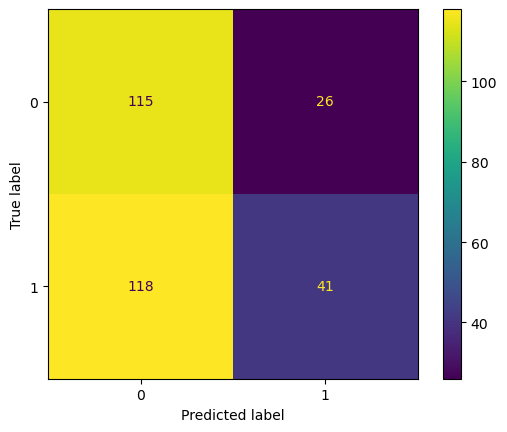

              precision    recall  f1-score   support

           0       0.50      0.83      0.62       141
           1       0.63      0.26      0.37       159

    accuracy                           0.53       300
   macro avg       0.56      0.54      0.49       300
weighted avg       0.57      0.53      0.49       300



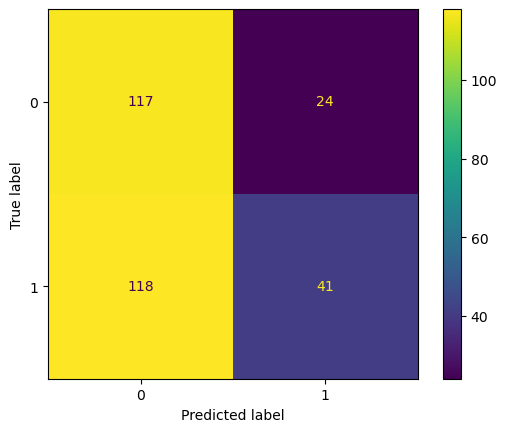

In [336]:
features_cut = ["RSI5", "RSI7", "RSI14", "RSI20", "CCI3", "CCI5", "CCI7", "CCI14", "CCI20", "SOMA37", "SOMA314", "MACD"]
rf_cut = RandomForestClassifier()

check_model(rf_cut, bitcoin_data, features_rfe, "Growth")
check_model(rf_cut, bitcoin_data, features_cut, "Growth")

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### It's time to evaluate models with some more reliable methods

I will use **TimeSeriesSplit** class to perform cross-validation on the data.

---
</div>

In [337]:
splitter = TimeSeriesSplit(n_splits=5)
splitter2 = TimeSeriesSplit(max_train_size=500, test_size=1, n_splits=5)

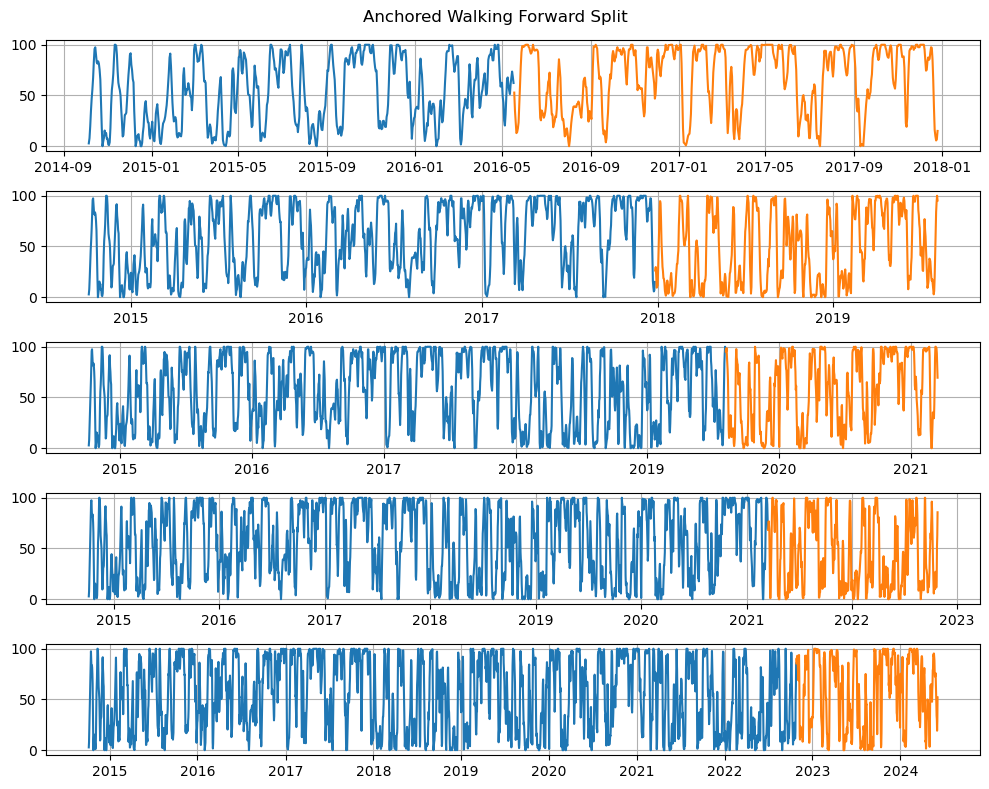

In [338]:
fig, axes = plt.subplots(figsize=(10, 8), nrows=5)

for ax, (x_s, t_s) in zip(axes.flatten(), splitter.split(bitcoin_data)):
    data_part_train = bitcoin_data.iloc[x_s, :]
    data_part_test = bitcoin_data.iloc[t_s, :]
    ax.plot(data_part_train["SOMA314"])
    ax.plot(data_part_test["SOMA314"])
    ax.grid()
fig.suptitle("Anchored Walking Forward Split")
plt.tight_layout()

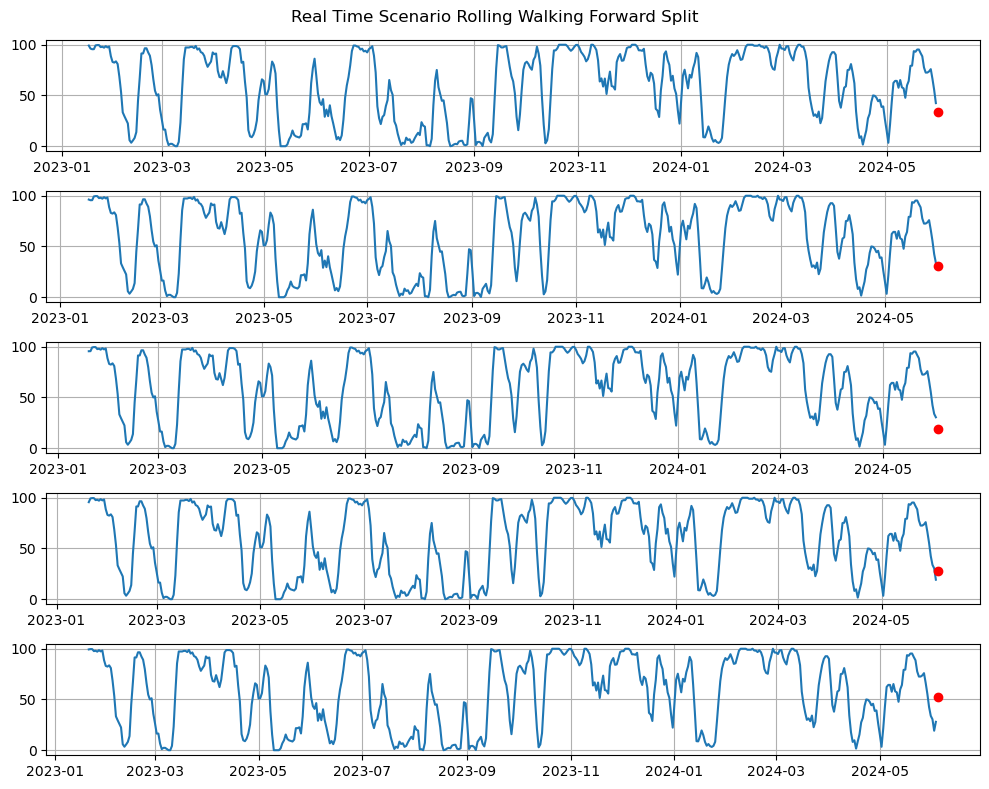

In [339]:
fig, axes = plt.subplots(figsize=(10, 8), nrows=5)

for ax, (x_s, t_s) in zip(axes.flatten(), splitter2.split(bitcoin_data)):
    data_part_train = bitcoin_data.iloc[x_s, :]
    data_part_test = bitcoin_data.iloc[t_s, :]
    ax.plot(data_part_train["SOMA314"])
    ax.plot(data_part_test["SOMA314"], "ro")
    ax.grid()
fig.suptitle("Real Time Scenario Rolling Walking Forward Split")
plt.tight_layout()

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Let's create some useful functions

These functions will be a more flexible tool to check the models, including the threshold for probabilities and different **Walk Forward** methods.

---
</div>

In [340]:
def prediction_scorer_threshold(model, X: np.ndarray, y: np.ndarray, threshold: float = 0.6, scoring=precision_score) -> float:
    """
    Calculates the given metric, classifing the class 1 under the condition of exceeding the given probability threshold..
    """
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob > threshold).astype(int)

    return scoring(y, y_pred, pos_label=1, zero_division=0)
    

def check_model_awf(model, X: np.ndarray, y: np.ndarray, splits: int = 5, threshold: float = 0.6) -> float:
    """
    Cross-validates the Time Series data with Anchored Walking Forward approach.
    """
    cvts = TimeSeriesSplit(n_splits=splits)
    output = cross_validate(model, X, y, cv=cvts, scoring={"Precision": partial(prediction_scorer_threshold, threshold=threshold),
                                                           "Recall": partial(prediction_scorer_threshold, threshold=threshold, scoring=recall_score)})

    return np.mean(output["test_Precision"]), np.mean(output["test_Recall"])


def check_model_rwf(model, X: np.ndarray, y: np.ndarray, max_train_size: int = 500, test_size: int = 100, threshold: float = 0.6) -> float:
    """
    Cross-validates the Time Series data with Rolling Walking Forward approach.
    """
    splits = (len(X)-max_train_size)//test_size
    cvts = TimeSeriesSplit(n_splits=splits, max_train_size=max_train_size, test_size=test_size)
    output = cross_validate(model, X, y, cv=cvts, scoring={"Precision": partial(prediction_scorer_threshold, threshold=threshold),
                                                           "Recall": partial(prediction_scorer_threshold, threshold=threshold, scoring=recall_score)})

    return np.mean(output["test_Precision"]), np.mean(output["test_Recall"])


def find_best_threshold(model, X: np.ndarray, y: np.ndarray, min_threshold: float = 0.5, max_threshold: float = 0.6, step: float = 0.01,
                                                             awf_splits: int = 5, rwf_max_train_size: int = 500, rwf_test_size: int = 100) -> None:
    """
    Prints the model performance with both - anchored and rolling walking forward CVs, for different thresholds.
    """
    
    for thr in np.arange(min_threshold, max_threshold+step, step):
        a_precision, a_recall = check_model_awf(model, X, y, splits=awf_splits, threshold=thr)
        r_precision, r_recall = check_model_rwf(model, X, y, max_train_size=rwf_max_train_size, test_size=rwf_test_size, threshold=thr)
        print(f"-*-*- THRESHOLD = {round(thr, 2)} -*-*-")
        print(f"ANCHORED --- | PRECISION = {a_precision} | RECALL = {a_recall}")
        print(f"ROLLING --- | PRECISION = {r_precision} | RECALL = {r_recall}")
        print("\n\n")

In [341]:
Xf = bitcoin_data[features].values
yf = bitcoin_data["Growth"].values

Xfc = bitcoin_data[features_cut].values
yfc = bitcoin_data["Growth"].values

Xfr = bitcoin_data[features_rfe].values
yfr = bitcoin_data["Growth"].values

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---

# Searching for the best threshold

I will use threshold of **0.55** for **Random Forest**.

---
</div>

In [343]:
find_best_threshold(RandomForestClassifier(), Xfc, yfc, awf_splits=20, max_threshold=0.58)

-*-*- THRESHOLD = 0.5 -*-*-
ANCHORED --- | PRECISION = 0.5373230574669066 | RECALL = 0.5507781968030663
ROLLING --- | PRECISION = 0.5394515657917762 | RECALL = 0.5176239194058977



-*-*- THRESHOLD = 0.51 -*-*-
ANCHORED --- | PRECISION = 0.5378335604667973 | RECALL = 0.502588802660772
ROLLING --- | PRECISION = 0.5370099197548343 | RECALL = 0.487879530172966



-*-*- THRESHOLD = 0.52 -*-*-
ANCHORED --- | PRECISION = 0.5431606567626949 | RECALL = 0.48289395547502467
ROLLING --- | PRECISION = 0.538484605359103 | RECALL = 0.45785461565802515



-*-*- THRESHOLD = 0.53 -*-*-
ANCHORED --- | PRECISION = 0.5380574749693393 | RECALL = 0.43221163067868085
ROLLING --- | PRECISION = 0.5453707318144495 | RECALL = 0.4318951501212315



-*-*- THRESHOLD = 0.54 -*-*-
ANCHORED --- | PRECISION = 0.5293274186170798 | RECALL = 0.40420673716512445
ROLLING --- | PRECISION = 0.534612169706407 | RECALL = 0.3935836400454726



-*-*- THRESHOLD = 0.55 -*-*-
ANCHORED --- | PRECISION = 0.5479766282544183 | RECALL = 

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---

# Let's run the test once again

But this time look what features do the best.

---
</div>

In [344]:
titles = ["All features", "Features picked by rf importances", "Features picked by RFE"]
for name, (X, y) in zip(titles, [(Xf, yf), (Xfc, yfc), (Xfr, yfr)]):
    aw_precision, aw_recall = check_model_awf(rf, Xf, yf, splits=10, threshold=0.55)
    rw_precision, rw_recall = check_model_rwf(rf, Xf, yf, threshold=0.55)

    
    
    print(f"--- --- --- --- --- --- {name} --- --- --- --- --- ---")
    print("--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---")
    print(f"Precision: {aw_precision} | Recall: {aw_recall}")
    print("--- --- --- Raw Random Forest Rolling Walking Forward Cross-validation Score --- --- ---")
    print(f"Precision: {rw_precision} | Recall: {rw_recall}")
    print("\n\n\n")

--- --- --- --- --- --- All features --- --- --- --- --- ---
--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---
Precision: 0.5306155379699949 | Recall: 0.3768836796802353
--- --- --- Raw Random Forest Rolling Walking Forward Cross-validation Score --- --- ---
Precision: 0.5569854583249702 | Recall: 0.4209931031183614




--- --- --- --- --- --- Features picked by rf importances --- --- --- --- --- ---
--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---
Precision: 0.5348142523108643 | Recall: 0.38182471218862496
--- --- --- Raw Random Forest Rolling Walking Forward Cross-validation Score --- --- ---
Precision: 0.5570194282138867 | Recall: 0.42280921840136493




--- --- --- --- --- --- Features picked by RFE --- --- --- --- --- ---
--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---
Precision: 0.5464486022209186 | Recall: 0.39277043947786666
--- --- --- Raw Random Forest Ro

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Real Time Scenario cross validation

This function simply simulates the actual work that will be done by the classificators.

---
</div>

In [345]:
def cross_validate_rts(model, X, y, threshold=0.6):
    """
    Creates a Real-Time-Scenario backtesting cross-validation.
    """
    n_rows = len(X)
    cv = TimeSeriesSplit(max_train_size=n_rows-150, test_size=1, n_splits=150)
    y_test = []
    y_pred = []
    for train_id, test_id in cv.split(X):
        model.fit(X[train_id], y[train_id])
        y_prob = model.predict_proba(X[test_id])[:,1]
        y_pred.append(y_prob > threshold)
        y_test.append(y[test_id])
    return np.ravel(np.array(y_test)), np.ravel(np.array(y_pred))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
## Real-time-scenario for pure Random Forest estimator

---
</div>

In [346]:
res = cross_validate_rts(RandomForestClassifier(bootstrap=False), Xfc, yfc, threshold=0.55)

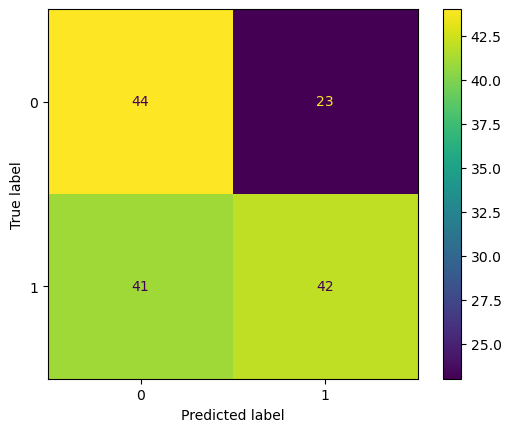

              precision    recall  f1-score   support

           0       0.52      0.66      0.58        67
           1       0.65      0.51      0.57        83

    accuracy                           0.57       150
   macro avg       0.58      0.58      0.57       150
weighted avg       0.59      0.57      0.57       150



In [348]:
yt, yp = res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---

# Creating the train and test dataset

I will create the data based on features evaluated by RFE. I will also create scaled version of the data for SVM.

**MinMaxScaler** is a **wrong choice** due to **EXTRAPOLATION**, we never know minimum and maximum!!!. However here I want to evaluate the model without this consideration.

---
</div>

In [24]:
scaler = MinMaxScaler()

X_train = Xfr[:3000]
X_test = Xfr[3000:]

y_train = yfr[:3000]
y_test = yfr[3000:]

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(Xfr)

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Hyperparams tuning - 1st run

**Params:**

- max_depth: 6
- n_estimators: 100

**Precision:** 0.584<br>
**Recall**: 0.382

---
</div>

In [125]:
params = {
    "max_depth": [6, 8, 12, 16, 20],
    "n_estimators": [100, 200, 300]
}

rf_cv = GridSearchCV(RandomForestClassifier(bootstrap=False),
                     params,
                     cv=TimeSeriesSplit(n_splits=20), 
                     scoring=partial(prediction_scorer_threshold, scoring=precision_score, threshold=0.53),
                     n_jobs=-1)

rf_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=None),
             estimator=RandomForestClassifier(bootstrap=False), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 12, 16, 20],
                         'n_estimators': [100, 200, 300]},
             scoring=functools.partial(<function prediction_scorer_threshold at 0x00000298DC178B80>, scoring=<function precision_score at 0x00000298C321AB60>, threshold=0.53))

In [132]:
print(rf_cv.best_params_)
print(rf_cv.best_score_)

check_model_awf(rf_cv.best_estimator_, X_train, y_train, threshold=0.53, splits=50)

{'max_depth': 6, 'n_estimators': 100}
0.5838982880589695


(0.5792459355394293, 0.3817741610595059)

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### 2nd run
It got worse

**Params**:

- max_depth: 4
- n_estimators: 100

**Precision:** 0.539<br>
**Recall**: 0.346

---
</div>

In [130]:
params = {
    "max_depth": [4, 5, 6, 7],
    "n_estimators": [100, 120, 150, 170]
}

rf_cv2 = GridSearchCV(RandomForestClassifier(bootstrap=False),
                     params,
                     cv=TimeSeriesSplit(n_splits=20), 
                     scoring=partial(prediction_scorer_threshold, scoring=precision_score, threshold=0.53),
                     n_jobs=-1)

rf_cv2.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=None),
             estimator=RandomForestClassifier(bootstrap=False), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7],
                         'n_estimators': [100, 120, 150, 170]},
             scoring=functools.partial(<function prediction_scorer_threshold at 0x00000298DC178B80>, scoring=<function precision_score at 0x00000298C321AB60>, threshold=0.53))

In [133]:
print(rf_cv2.best_params_)
print(rf_cv2.best_score_)

check_model_awf(rf_cv2.best_estimator_, X_train, y_train, threshold=0.53, splits=50)

{'max_depth': 4, 'n_estimators': 100}
0.5777617711499249


(0.5387903377390453, 0.3463542369407322)

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
## Checking the best Random Forest estimator in real-time-scenario

It gave the wrong "buy" decision only 3 times, however missess about 70% of opportunities.<br>
It's not bad, however it is also not perfect.

---
</div>

In [134]:
rf_best = RandomForestClassifier(bootstrap=False, max_depth=6, n_estimators=100)

rfb_res = cross_validate_rts(rf_best, Xfr, yfr, threshold=0.53)

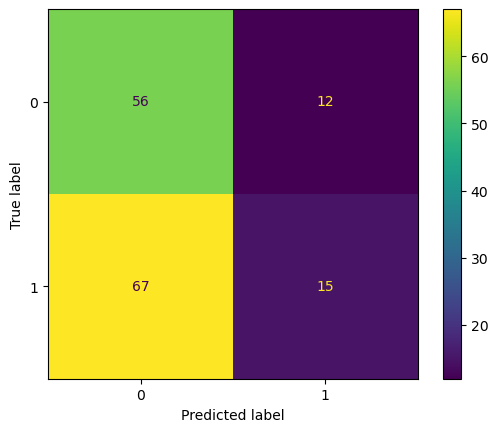

              precision    recall  f1-score   support

           0       0.46      0.82      0.59        68
           1       0.56      0.18      0.28        82

    accuracy                           0.47       150
   macro avg       0.51      0.50      0.43       150
weighted avg       0.51      0.47      0.42       150



In [135]:
yt, yp = rfb_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
# Support Vector Machines

Now let's check how the **SVM** will do with this problem.<br>
I am going to pick threshold of **0.52** for **SVM**.<br>
<br>
Another thing, that I have noticed is the time it takes SVM and RF to train and predict. It is way better in terms of SVM.

---
</div>

In [136]:
find_best_threshold(SVC(probability=True), X_train_scaled, y_train, awf_splits=20, max_threshold=0.58)

-*-*- THRESHOLD = 0.5 -*-*-
ANCHORED --- | PRECISION = 0.5379595659921294 | RECALL = 0.9561364704625573
ROLLING --- | PRECISION = 0.5105645018969741 | RECALL = 0.7474927395918616



-*-*- THRESHOLD = 0.51 -*-*-
ANCHORED --- | PRECISION = 0.5390832152301641 | RECALL = 0.9696989459815546
ROLLING --- | PRECISION = 0.49378415300256817 | RECALL = 0.7212954082847728



-*-*- THRESHOLD = 0.52 -*-*-
ANCHORED --- | PRECISION = 0.540516059069891 | RECALL = 0.9169323916546916
ROLLING --- | PRECISION = 0.4900331602125836 | RECALL = 0.5971765850211951



-*-*- THRESHOLD = 0.53 -*-*-
ANCHORED --- | PRECISION = 0.5392814531865929 | RECALL = 0.8540817998195278
ROLLING --- | PRECISION = 0.4655962850552065 | RECALL = 0.5352287408004318



-*-*- THRESHOLD = 0.54 -*-*-
ANCHORED --- | PRECISION = 0.5562896699606555 | RECALL = 0.7465617158850957
ROLLING --- | PRECISION = 0.4025006646600475 | RECALL = 0.4560207271737414



-*-*- THRESHOLD = 0.55 -*-*-
ANCHORED --- | PRECISION = 0.5318490626779352 | RECALL = 

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---


# Let's run it once again



---
</div>

In [137]:
aw_precision, aw_recall = check_model_awf(SVC(probability=True), X_train_scaled, y_train, splits=20, threshold=0.52)
rw_precision, rw_recall = check_model_rwf(SVC(probability=True), X_train_scaled, y_train, threshold=0.52)
   
print("--- --- --- --- --- --- SVC --- --- --- --- --- ---")
print("--- --- --- Raw SVC Anchored Walking Forward Cross-validation Score --- --- ---")
print(f"Precision: {aw_precision} | Recall: {aw_recall}")
print("--- --- --- Raw SVC Rolling Walking Forward Cross-validation Score --- --- ---")
print(f"Precision: {rw_precision} | Recall: {rw_recall}")
print("\n\n\n")

--- --- --- --- --- --- SVC --- --- --- --- --- ---
--- --- --- Raw SVC Anchored Walking Forward Cross-validation Score --- --- ---
Precision: 0.5381318610823993 | Recall: 0.9233712705194025
--- --- --- Raw SVC Rolling Walking Forward Cross-validation Score --- --- ---
Precision: 0.48443033828916177 | Recall: 0.5583413476147545






---

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---


# Quite low precision, but high recall

Let's try to optimize precision for this given threshold.



---
</div>

In [138]:
params = {
    "C": [1, 10, 50, 100, 200, 300],
    "gamma": [1, 0.1, 0.001, 0.0001],
    "kernel": ["linear", "rbf"]
}

svm_cv = GridSearchCV(SVC(probability=True),
                     params,
                     cv=TimeSeriesSplit(n_splits=20), 
                     scoring=partial(prediction_scorer_threshold, threshold=0.52),
                     n_jobs=-1)

svm_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=None),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100, 200, 300],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             scoring=functools.partial(<function prediction_scorer_threshold at 0x00000298DC178B80>, threshold=0.52))

In [140]:
print(svm_cv.best_score_)
print(svm_cv.best_params_)

check_model_awf(svm_cv.best_estimator_, X_train_scaled, y_train, splits=50, threshold=0.52)

0.5460742295882749
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


(0.5397811598561266, 0.9099445531939239)

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### 2nd run

**Params**:

- C: 5
- gamma: 1
- kernel: rbf

**Precision:** 0.543<br>
**Recall:** 0.878

---
</div>

In [141]:
params = {
    "C": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
    "gamma": [1, 0.9, 0.8]
}

svm_cv2 = GridSearchCV(SVC(kernel="rbf", probability=True),
                     params,
                     cv=TimeSeriesSplit(n_splits=20), 
                     scoring=partial(prediction_scorer_threshold, threshold=0.52),
                     n_jobs=-1)

svm_cv2.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=None),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                         'gamma': [1, 0.9, 0.8]},
             scoring=functools.partial(<function prediction_scorer_threshold at 0x00000298DC178B80>, threshold=0.52))

In [143]:
print(svm_cv2.best_score_)
print(svm_cv2.best_params_)

check_model_awf(svm_cv2.best_estimator_, X_train_scaled, y_train, splits=50, threshold=0.52)

0.547640356030299
{'C': 5, 'gamma': 1}


(0.542977770391299, 0.8780705340450088)

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### WARNING!!!

LONG TIME OF EXECUTION

---
</div>

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Evaluation on Real-Time-Scenario

I will evaluate on anchored version, however there is a function for a rolling one.

---
</div>

In [144]:
def cross_validate_rts_na(model: object, X: np.array, y: np.array, threshold: float = 0.6, n_days: int = 150): # non anchored
    cv = TimeSeriesSplit(max_train_size=500, test_size=1, n_splits=n_days)
    y_test = []
    y_pred = []
    for train_id, test_id in cv.split(X):
        model.fit(X[train_id], y[train_id])
        y_prob = model.predict_proba(X[test_id])[:,1]
        y_pred.append(y_prob > threshold)
        y_test.append(y[test_id])
    return np.ravel(np.array(y_test)), np.ravel(np.array(y_pred))

In [145]:
svm_best = svm_cv2.best_estimator_
svm_res = cross_validate_rts(svm_best, X_scaled, yfr, threshold=0.52)

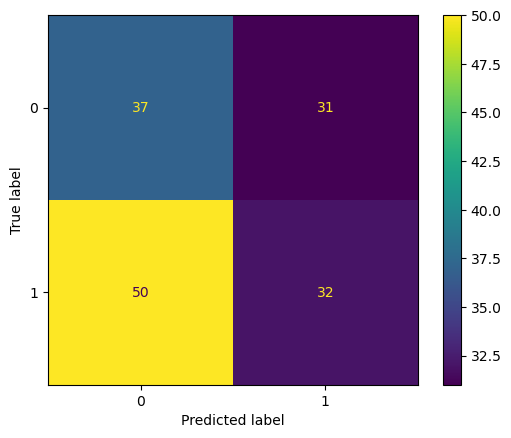

              precision    recall  f1-score   support

           0       0.43      0.54      0.48        68
           1       0.51      0.39      0.44        82

    accuracy                           0.46       150
   macro avg       0.47      0.47      0.46       150
weighted avg       0.47      0.46      0.46       150



In [146]:
yt, yp = svm_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
# AdaBoost

The best threshold seems to be 0.5

---
</div>

In [148]:
find_best_threshold(AdaBoostClassifier(algorithm="SAMME"), X_train, y_train, awf_splits=20, max_threshold=0.58)

-*-*- THRESHOLD = 0.5 -*-*-
ANCHORED --- | PRECISION = 0.5419278475468022 | RECALL = 0.649942146650335
ROLLING --- | PRECISION = 0.48629684646601207 | RECALL = 0.5163753966122855



-*-*- THRESHOLD = 0.51 -*-*-
ANCHORED --- | PRECISION = 0.5339378480695933 | RECALL = 0.6014603628137125
ROLLING --- | PRECISION = 0.47943893413077504 | RECALL = 0.4895542037475659



-*-*- THRESHOLD = 0.52 -*-*-
ANCHORED --- | PRECISION = 0.5121416288178233 | RECALL = 0.4744319043718369
ROLLING --- | PRECISION = 0.48975184126981813 | RECALL = 0.45030119093773147



-*-*- THRESHOLD = 0.53 -*-*-
ANCHORED --- | PRECISION = 0.47875398900394617 | RECALL = 0.3512583011262852
ROLLING --- | PRECISION = 0.4541967034373615 | RECALL = 0.382878766177618



-*-*- THRESHOLD = 0.54 -*-*-
ANCHORED --- | PRECISION = 0.44633235662825177 | RECALL = 0.3125439221989245
ROLLING --- | PRECISION = 0.4219007587728939 | RECALL = 0.3614803346543259



-*-*- THRESHOLD = 0.55 -*-*-
ANCHORED --- | PRECISION = 0.38550678572468233 | RECA

In [149]:
print("--- --- --- --- --- --- AdaBoost --- --- --- --- --- ---")
print("--- --- --- Raw AdaBoost Anchored Walking Forward Cross-validation Score --- --- ---")
print(check_model_awf(AdaBoostClassifier(algorithm="SAMME"), X_train, y_train, splits=20, threshold=0.5))
print("--- --- --- Raw AdaBoost Rolling Walking Forward Cross-validation Score --- --- ---")
print(check_model_rwf(AdaBoostClassifier(algorithm="SAMME"), X_train, y_train, threshold=0.5))
print("\n\n\n")

--- --- --- --- --- --- AdaBoost --- --- --- --- --- ---
--- --- --- Raw AdaBoost Anchored Walking Forward Cross-validation Score --- --- ---
(0.5419278475468022, 0.649942146650335)
--- --- --- Raw AdaBoost Rolling Walking Forward Cross-validation Score --- --- ---
(0.48629684646601207, 0.5163753966122855)






<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### AdaBoost in RTS

It gives **62% precision**, but with only **40% of recall**.

---
</div>

In [150]:
ada_res = cross_validate_rts(AdaBoostClassifier(algorithm="SAMME"), Xfr, yfr, threshold=0.5)

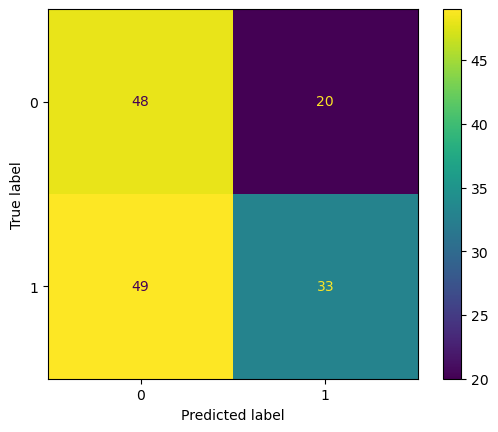

              precision    recall  f1-score   support

           0       0.49      0.71      0.58        68
           1       0.62      0.40      0.49        82

    accuracy                           0.54       150
   macro avg       0.56      0.55      0.54       150
weighted avg       0.56      0.54      0.53       150



In [151]:
yt, yp = ada_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
# AdaBoost hypertuning

There is not much to change in terms of this estimator, however it can serve as an **ultimate agreement** in terms of decision (additional confirmation).

---
</div>

In [156]:
params = {
    "n_estimators": [250, 300, 350, 400, 450, 500],
    "learning_rate": [1, 0.7, 0.8, 0.9]
}

ada_cv = GridSearchCV(AdaBoostClassifier(algorithm="SAMME"),
                      params,
                      cv=TimeSeriesSplit(n_splits=30),
                      scoring=partial(prediction_scorer_threshold, scoring=precision_score, threshold=0.5),
                      n_jobs=-1)

ada_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=30, test_size=None),
             estimator=AdaBoostClassifier(algorithm='SAMME'), n_jobs=-1,
             param_grid={'learning_rate': [1, 0.7, 0.8, 0.9],
                         'n_estimators': [250, 300, 350, 400, 450, 500]},
             scoring=functools.partial(<function prediction_scorer_threshold at 0x00000298DC178B80>, scoring=<function precision_score at 0x00000298C321AB60>, threshold=0.5))

In [158]:
print(ada_cv.best_params_)
print(ada_cv.best_score_)

check_model_awf(ada_cv.best_estimator_, X_train, y_train, splits=50, threshold=0.5)

{'learning_rate': 1, 'n_estimators': 500}
0.5588901141343567


(0.5636848659518818, 0.5277017010512385)

In [159]:
ada_best = ada_cv.best_estimator_
ada_res = cross_validate_rts(ada_best, Xfr, yfr, threshold=0.5)

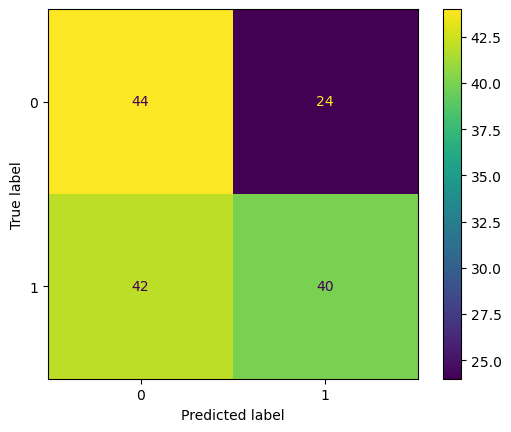

              precision    recall  f1-score   support

           0       0.51      0.65      0.57        68
           1       0.62      0.49      0.55        82

    accuracy                           0.56       150
   macro avg       0.57      0.57      0.56       150
weighted avg       0.57      0.56      0.56       150



In [160]:
yt, yp = ada_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
# GradientBoost

Let's start with RTS cross-validation.<br>
It looks like it has potential and I can go with further optimalization.<br>
I'll go with threshold = **0.55**

---
</div>

In [24]:
find_best_threshold(GradientBoostingClassifier(), X_train, y_train, awf_splits=20, max_threshold=0.58)

-*-*- THRESHOLD = 0.5 -*-*-
ANCHORED --- | PRECISION = 0.5700176571371559 | RECALL = 0.45128968741763514
ROLLING --- | PRECISION = 0.5100233948622246 | RECALL = 0.49891860437330643



-*-*- THRESHOLD = 0.51 -*-*-
ANCHORED --- | PRECISION = 0.571878353504417 | RECALL = 0.41520915472405795
ROLLING --- | PRECISION = 0.5653163690316817 | RECALL = 0.4813411703688148



-*-*- THRESHOLD = 0.52 -*-*-
ANCHORED --- | PRECISION = 0.5752115708677105 | RECALL = 0.3955769118359694
ROLLING --- | PRECISION = 0.5395039962620876 | RECALL = 0.47561502226645513



-*-*- THRESHOLD = 0.53 -*-*-
ANCHORED --- | PRECISION = 0.5724002207446437 | RECALL = 0.379917965903321
ROLLING --- | PRECISION = 0.5496920372786741 | RECALL = 0.45946669642125293



-*-*- THRESHOLD = 0.54 -*-*-
ANCHORED --- | PRECISION = 0.5836415873510843 | RECALL = 0.3561839999986718
ROLLING --- | PRECISION = 0.5497416031161962 | RECALL = 0.44285318003270113



-*-*- THRESHOLD = 0.55 -*-*-
ANCHORED --- | PRECISION = 0.5945569933351258 | RECAL

In [27]:
gb_res = cross_validate_rts(GradientBoostingClassifier(), Xfr, yfr, threshold=0.55)

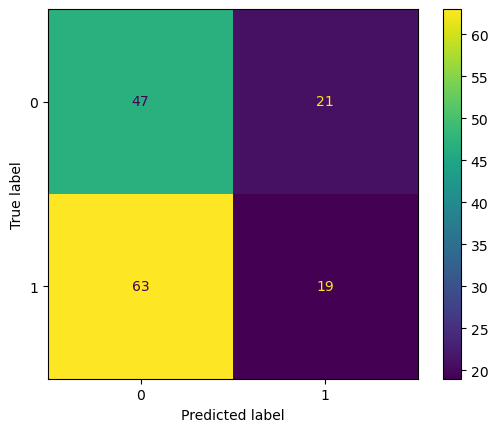

              precision    recall  f1-score   support

           0       0.43      0.69      0.53        68
           1       0.47      0.23      0.31        82

    accuracy                           0.44       150
   macro avg       0.45      0.46      0.42       150
weighted avg       0.45      0.44      0.41       150



In [28]:
yt, yp = gb_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Hypertuning - 1st run

---
</div>


In [29]:
params = {
    "learning_rate": [0.1, 0.2, 0.3, 0.4],
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [3, 5, 7, 9]
}

gb_cv = GridSearchCV(GradientBoostingClassifier(), 
                     params,
                     cv=TimeSeriesSplit(n_splits=20),
                     scoring=partial(prediction_scorer_threshold, threshold=0.55),
                     n_jobs=-1)

gb_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=None),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 200, 300, 400]},
             scoring=functools.partial(<function prediction_scorer_threshold at 0x000001A03A387240>, threshold=0.55))

In [31]:
print(gb_cv.best_params_)
print(gb_cv.best_score_)

check_model_awf(gb_cv.best_estimator_, X_train, y_train, splits=50, threshold=0.55)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.5926991562574182


(0.6031330560635189, 0.35049569404994435)

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### 2nd run

**Params**:

- learning_rate: **0.05**
- max_depth: **3**
- n_estimators: **100**

---
</div>

In [32]:
params = {
    "learning_rate": [0.05, 0.1, 0.15],
    "n_estimators": [50, 100, 150],
    "max_depth": [3, 4]
}

gb_cv2 = GridSearchCV(GradientBoostingClassifier(), 
                     params,
                     cv=TimeSeriesSplit(n_splits=20),
                     scoring=partial(prediction_scorer_threshold, threshold=0.55),
                     n_jobs=-1)

gb_cv2.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=None),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [3, 4], 'n_estimators': [50, 100, 150]},
             scoring=functools.partial(<function prediction_scorer_threshold at 0x000001A03A387240>, threshold=0.55))

In [33]:
print(gb_cv2.best_params_)
print(gb_cv2.best_score_)

check_model_awf(gb_cv2.best_estimator_, X_train, y_train, splits=50, threshold=0.55)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
0.6391026508493498


(0.6185063091424731, 0.29391099084834377)

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### 3rd run

**Params:**

- learning_rate: **0.04**
- max_depth: **3**
- n_estimators: **110**

---
</div>

In [34]:
params = {
    "learning_rate": [0.04, 0.05, 0.06],
    "n_estimators": [50, 60, 70],
    "max_depth": [3, 4]
}

gb_cv3 = GridSearchCV(GradientBoostingClassifier(), 
                     params,
                     cv=TimeSeriesSplit(n_splits=20),
                     scoring=partial(prediction_scorer_threshold, threshold=0.55),
                     n_jobs=-1)

gb_cv3.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=None),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.04, 0.05, 0.06],
                         'max_depth': [3, 4], 'n_estimators': [50, 60, 70]},
             scoring=functools.partial(<function prediction_scorer_threshold at 0x000001A03A387240>, threshold=0.55))

In [35]:
print(gb_cv3.best_params_)
print(gb_cv3.best_score_)
check_model_awf(gb_cv3.best_estimator_, X_train, y_train, splits=50, threshold=0.55)

{'learning_rate': 0.06, 'max_depth': 4, 'n_estimators': 70}
0.6202585580097713


(0.5946019259275048, 0.32571148911147446)

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### RTS check for GradientBoost
This model performs well, however it is nothing compared to SVM.<br>
Either way, I am going also include it inside the final predictors list.

---
</div>

In [36]:
gb_best = gb_cv3.best_estimator_
gb_res = cross_validate_rts(gb_best, Xfr, yfr, threshold=0.55)

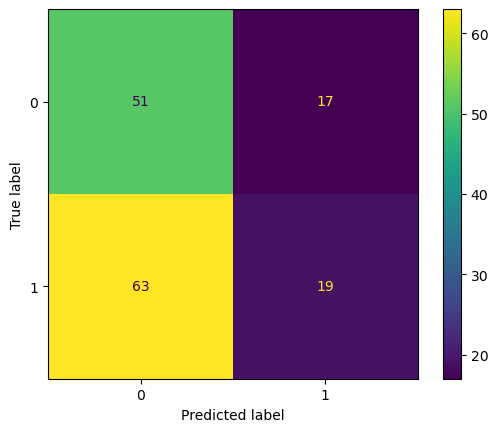

              precision    recall  f1-score   support

           0       0.45      0.75      0.56        68
           1       0.53      0.23      0.32        82

    accuracy                           0.47       150
   macro avg       0.49      0.49      0.44       150
weighted avg       0.49      0.47      0.43       150



In [37]:
yt, yp = gb_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
# Removing prices from features with proper standardization

This time I will not use prices 

---
</div>